In [1]:
import pycrfsuite

In [2]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
from _chain import Chain

### Define Binary HMM 

In [5]:
def f_phi(x1, x2):
    p = np.array([
    [0.58, 0.42],
    [0.42, 0.58]])
    return p[x1, x2]

In [6]:
def f_psi(x1, x2):
    p = np.array([
    [0.62, 0.38],
    [0.34, 0.66]])
    return p[x1, x2]

In [7]:
phi = f_phi
psi = f_psi

In [8]:
T = 50 # chain length

In [9]:
chain = Chain(length=T, phi=phi, psi=psi, possible_values=[0, 1])

### Create Random Trainset

In [10]:
possible_values = [0, 1]

In [11]:
N = 1000

In [13]:
%%time 

X_dataset = []
y_dataset= []

for i in range(N):
    x = np.random.rand(T)
    x_binary = 1 * (x > 0.5)
    
    chain.update_observed(x_binary)
    y = chain.get_max_apostriori_beliefs()

    X_dataset.append(x_binary)
    y_dataset.append(y)

CPU times: user 2.05 s, sys: 13.2 ms, total: 2.07 s
Wall time: 2.06 s


In [14]:
# turn to numpy arrays
X_dataset = np.array([np.array(xi) for xi in X_dataset])
y_dataset = np.array([np.array(yi) for yi in y_dataset])

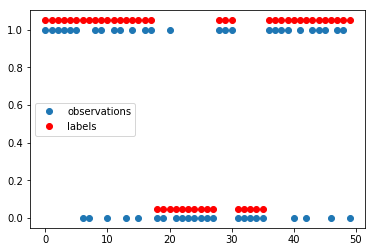

In [16]:
plot(X_dataset[0], 'o')
plot(y_dataset[0] + 0.05, 'ro')
legend(['observations', 'labels'])

### Play with HMM implementation

In [40]:
import mchmm as mc
hmm = mc.HiddenMarkovModel()

In [41]:
ep = np.array([
    [0.62, 0.38],
    [0.38, 0.62]])

In [42]:
tp = np.array([
    [0.62, 0.38],
    [0.38, 0.62]])

In [39]:
hmm.observations = hmm.states = np.array([0, 1])

In [106]:
pi = np.array([0.5, 0.5])

In [107]:
%%time 

X_dataset = []
y_dataset= []

for i in range(N):
    x = np.random.rand(T)
    x_binary = np.array(1 * (x > 0.5))
    
    y = hmm.viterbi(x_binary, tp=tp, ep=ep, pi=pi)[0]

    X_dataset.append(x_binary)
    y_dataset.append(y)

CPU times: user 1.81 s, sys: 9.26 ms, total: 1.82 s
Wall time: 1.82 s


In [108]:
# turn to numpy arrays
X_dataset = np.array([np.array(xi) for xi in X_dataset])
y_dataset = np.array([np.array(yi) for yi in y_dataset])

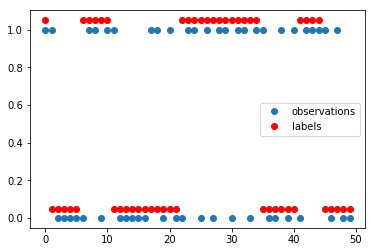

In [109]:
plot(X_dataset[0], 'o')
plot(y_dataset[0] + 0.05, 'ro')
legend(['observations', 'labels'])

### Train Dummy Model (predicts y = x)

#### Train-Test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2)

#### Evaluate 

In [18]:
y_pred = X_test

In [19]:
labels = {0 : 0, 1: 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.39      0.81      0.53      2409
           1       0.91      0.60      0.72      7591

   micro avg       0.65      0.65      0.65     10000
   macro avg       0.65      0.70      0.62     10000
weighted avg       0.78      0.65      0.67     10000



### Train CRF

In [20]:
def extract_features(x):
    features = [
        'x.current=' + str(x)
    ]
    return features

In [21]:
def extract_labels(y):
    return str(y)

#### Preprocess Dataset

In [22]:
X = []
y = []

for xseq, yseq in zip(X_dataset, y_dataset):
    X_features = [extract_features(x_i) for x_i in xseq]
    y_labels = [extract_labels(y_i) for y_i in yseq]
    
    X.append(X_features)
    y.append(y_labels)

#### Train-Test split 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Train 

In [24]:
trainer = pycrfsuite.Trainer(verbose=True)

In [25]:
# Submit training data to the trainer
trainer.clear()
    
for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

In [26]:
rm crf.model

In [27]:
# the model will be saved under 'crf.model'
trainer.train('crf.model')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 8
Seconds required: 0.006

L-BFGS optimization
c1: 0.000000
c2: 1.000000
num_memories: 6
max_iterations: 2147483647
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 14645.746111
Feature norm: 1.000000
Error norm: 10992.618377
Active features: 8
Line search trials: 1
Line search step: 0.000038
Seconds required for this iteration: 0.009

***** Iteration #2 *****
Loss: 11263.744806
Feature norm: 1.151549
Error norm: 9504.225943
Active features: 8
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.006

***** Iteration #3 *****
Loss: 7014.228138
Feature norm: 1.572131
Error norm: 5281.252126
Active features: 8
Line search trials: 2
Line search step: 0.195758
Seconds required for this iterat

####  Evaluate

In [28]:
tagger = pycrfsuite.Tagger()
tagger.open('crf.model')

y_pred = [tagger.tag(xseq) for xseq in X_test]

In [29]:
# Create a mapping of labels to indices
labels = {"0": 0, "1": 1}

# Convert the sequences of tags into a 1-dimensional array
predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

# Print out the classification report
print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2529
           1       0.99      1.00      1.00      7471

   micro avg       1.00      1.00      1.00     10000
   macro avg       1.00      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000



### Try using sklearn.CRF wrapper

In [30]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [31]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=1000,
    all_possible_transitions=True,
    all_possible_states=True
)
crf.fit(X_train, y_train)

CPU times: user 7.2 s, sys: 18.5 ms, total: 7.22 s
Wall time: 7.22 s


In [32]:
y_pred = crf.predict(X_test)

In [33]:
labels = list(crf.classes_)
labels

['1', '0']

In [34]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           0      1.000     0.991     0.995      2529
           1      0.997     1.000     0.998      7471

   micro avg      0.998     0.998     0.998     10000
   macro avg      0.998     0.995     0.997     10000
weighted avg      0.998     0.998     0.998     10000



In [72]:
crf

CRF(algorithm='lbfgs', all_possible_states=True,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=1000,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [73]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

Transitions:
1      -> 1       7.526609
0      -> 0       1.810091
0      -> 1       -4.835363
1      -> 0       -4.839872


In [74]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("States:")
print_state_features(Counter(crf.state_features_).most_common(30))

States:
9.845891 1        x.current=1
9.169897 0        x.current=0
-9.169897 1        x.current=0
-9.845891 0        x.current=1


In [356]:
import scipy
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [357]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   56.2s finished


CPU times: user 55.4 s, sys: 600 ms, total: 56 s
Wall time: 56.5 s


In [358]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 2.601810142324518, 'c2': 0.13253074750872607}
best CV score: 0.9714514252075627
model size: 0.00M


### Training FC NN 

#### Define 

In [75]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [76]:
n_epochs = 1000
batch_size, D_in, D_hidden, D_out = 64, T, 2 * T, T

In [77]:
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_out),
          torch.nn.Sigmoid()
        )

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [78]:
from torch.utils.data import Dataset

class ChainDataset(Dataset):
    
    def __init__(self, X, y, flatten=True):
        self._X = X
        self._y = y

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        sample = {
            'X': torch.from_numpy(self._X[idx]).float(),
            'y': torch.from_numpy(self._y[idx]).float()  
        }
        return sample

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2)

In [80]:
trainset = ChainDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#### Train 

In [81]:
model.train()
learning_curve = []

for epoch in range(1, n_epochs + 1):
    
    for batch in trainloader:
        
        X_batch, y_batch = Variable(batch['X']), Variable(batch['y'])
        model.zero_grad()
        
        y_pred = model(X_batch)
        loss = F.binary_cross_entropy(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print('epoch {}:: loss = {}'. format(epoch, loss))
        learning_curve.append(loss)

epoch 10:: loss = 0.10650727152824402
epoch 20:: loss = 0.04566825553774834
epoch 30:: loss = 0.026204504072666168
epoch 40:: loss = 0.017075013369321823
epoch 50:: loss = 0.009916340932250023
epoch 60:: loss = 0.0056252386420965195
epoch 70:: loss = 0.003228597342967987
epoch 80:: loss = 0.0025141153018921614
epoch 90:: loss = 0.0020708285737782717
epoch 100:: loss = 0.0016462387284263968
epoch 110:: loss = 0.0012459862045943737
epoch 120:: loss = 0.0011442226823419333
epoch 130:: loss = 0.0009900436270982027
epoch 140:: loss = 0.0007349085644818842
epoch 150:: loss = 0.0006284206174314022
epoch 160:: loss = 0.0005654201377183199
epoch 170:: loss = 0.00048245344078168273
epoch 180:: loss = 0.00040644436376169324
epoch 190:: loss = 0.000341401289915666
epoch 200:: loss = 0.0003388235636521131
epoch 210:: loss = 0.0002876607468351722
epoch 220:: loss = 0.0002512266510166228
epoch 230:: loss = 0.00022231394541449845
epoch 240:: loss = 0.00020567137107718736
epoch 250:: loss = 0.000171458

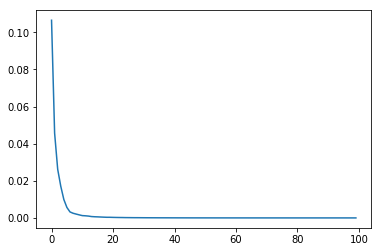

In [82]:
plot(learning_curve);

#### Evaluate 

In [83]:
model.eval()

Sequential(
  (0): Linear(in_features=50, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): Sigmoid()
)

In [87]:
y_pred = np.array([model(torch.from_numpy(xseq).float()).detach().numpy() for xseq in X_test])

In [88]:
y_pred = 1 * (y_pred > 0.5)

In [89]:
labels = {0 : 0, 1: 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3722
           1       1.00      1.00      1.00      6278

   micro avg       1.00      1.00      1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



### Create dataset from trained CRF

In [30]:
tagger = pycrfsuite.Tagger()
tagger.open('crf.model')

y_pred_test = [tagger.tag(xseq) for xseq in X_test]
y_pred_train = [tagger.tag(xseq) for xseq in X_train]

#### Train new CRF over the generated dataset

In [31]:
chain.update_observed([int(c[0].split('=')[1]) for c in X_train[0]])
y_chain = chain.get_max_apostriori_beliefs()

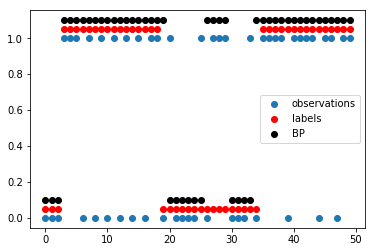

In [32]:
plot([int(c[0].split('=')[1]) for c in X_train[0]], 'o')
plot([int(c) + 0.05 for c in y_pred_train[0]], 'ro')
plot(np.array(y_chain) + 0.1, 'ko')
legend(['observations', 'labels', 'BP'])

In [ ]:
trainer = pycrfsuite.Trainer(verbose=True)

In [ ]:
# Submit training data to the trainer
trainer.clear()
    
for xseq, yseq in zip(X_train, y_pred_train):
    trainer.append(xseq, yseq)

In [ ]:
# the model will be saved under 'crf.model'
trainer.train('crf_from_crf_created_data.model')

In [ ]:
tagger = pycrfsuite.Tagger()
tagger.open('crf_from_crf_created_data.model')

y_pred = [tagger.tag(xseq) for xseq in X_test]

In [ ]:
labels = {"0": 0, "1": 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_pred_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

In [13]:
# 50 devices, 100K sessions
FAUW = {'(0.5, 0.5, 0.5)_per_week': 13.708333333333332,
 '(0.5, 0.5, 0.6)_per_week': 11.433333333333334,
 '(0.5, 0.5, 0.7)_per_week': 10.75,
 '(0.5, 0.5, 0.8)_per_week': 7.0,
 '(0.5, 0.5, 0.85)_per_week': 7.0,
 '(0.5, 0.6, 0.5)_per_week': 12.25,
 '(0.5, 0.6, 0.6)_per_week': 10.85,
 '(0.5, 0.6, 0.7)_per_week': 10.75,
 '(0.5, 0.6, 0.8)_per_week': 7.0,
 '(0.5, 0.6, 0.85)_per_week': 6.0625,
 '(0.5, 0.7, 0.5)_per_week': 11.433333333333334,
 '(0.5, 0.7, 0.6)_per_week': 9.8,
 '(0.5, 0.7, 0.7)_per_week': 8.5,
 '(0.5, 0.7, 0.8)_per_week': 7.0,
 '(0.5, 0.7, 0.85)_per_week': 5.916666666666666,
 '(0.5, 0.75, 0.5)_per_week': 10.733333333333334,
 '(0.5, 0.75, 0.6)_per_week': 9.100000000000001,
 '(0.5, 0.75, 0.7)_per_week': 8.166666666666668,
 '(0.5, 0.75, 0.8)_per_week': 6.125,
 '(0.5, 0.75, 0.85)_per_week': 5.541666666666666,
 '(0.6, 0.5, 0.5)_per_week': 10.5,
 '(0.6, 0.5, 0.6)_per_week': 8.866666666666667,
 '(0.6, 0.5, 0.7)_per_week': 7.583333333333333,
 '(0.6, 0.5, 0.8)_per_week': 7.0,
 '(0.6, 0.5, 0.85)_per_week': 5.075,
 '(0.6, 0.6, 0.5)_per_week': 9.333333333333334,
 '(0.6, 0.6, 0.6)_per_week': 7.7,
 '(0.6, 0.6, 0.7)_per_week': 7.0,
 '(0.6, 0.6, 0.8)_per_week': 5.833333333333333,
 '(0.6, 0.6, 0.85)_per_week': 4.783333333333333,
 '(0.6, 0.7, 0.5)_per_week': 9.333333333333334,
 '(0.6, 0.7, 0.6)_per_week': 7.0,
 '(0.6, 0.7, 0.7)_per_week': 7.0,
 '(0.6, 0.7, 0.8)_per_week': 5.541666666666666,
 '(0.6, 0.7, 0.85)_per_week': 4.666666666666667,
 '(0.6, 0.75, 0.5)_per_week': 8.866666666666667,
 '(0.6, 0.75, 0.6)_per_week': 7.0,
 '(0.6, 0.75, 0.7)_per_week': 6.5,
 '(0.6, 0.75, 0.8)_per_week': 5.125,
 '(0.6, 0.75, 0.85)_per_week': 4.433333333333334,
 '(0.7, 0.5, 0.5)_per_week': 9.333333333333334,
 '(0.7, 0.5, 0.6)_per_week': 7.583333333333333,
 '(0.7, 0.5, 0.7)_per_week': 6.15,
 '(0.7, 0.5, 0.8)_per_week': 5.25,
 '(0.7, 0.5, 0.85)_per_week': 4.375,
 '(0.7, 0.6, 0.5)_per_week': 8.866666666666667,
 '(0.7, 0.6, 0.6)_per_week': 7.0,
 '(0.7, 0.6, 0.7)_per_week': 6.0625,
 '(0.7, 0.6, 0.8)_per_week': 4.666666666666667,
 '(0.7, 0.6, 0.85)_per_week': 3.75,
 '(0.7, 0.7, 0.5)_per_week': 8.7,
 '(0.7, 0.7, 0.6)_per_week': 6.15,
 '(0.7, 0.7, 0.7)_per_week': 5.916666666666666,
 '(0.7, 0.7, 0.8)_per_week': 4.666666666666667,
 '(0.7, 0.7, 0.85)_per_week': 3.5,
 '(0.7, 0.75, 0.5)_per_week': 7.5,
 '(0.7, 0.75, 0.6)_per_week': 5.916666666666666,
 '(0.7, 0.75, 0.7)_per_week': 5.541666666666666,
 '(0.7, 0.75, 0.8)_per_week': 4.520833333333334,
 '(0.7, 0.75, 0.85)_per_week': 3.25,
 '(0.8, 0.5, 0.5)_per_week': 5.625,
 '(0.8, 0.5, 0.6)_per_week': 4.666666666666667,
 '(0.8, 0.5, 0.7)_per_week': 4.783333333333333,
 '(0.8, 0.5, 0.8)_per_week': 3.5,
 '(0.8, 0.5, 0.85)_per_week': 2.3333333333333335,
 '(0.8, 0.6, 0.5)_per_week': 5.25,
 '(0.8, 0.6, 0.6)_per_week': 4.666666666666667,
 '(0.8, 0.6, 0.7)_per_week': 4.375,
 '(0.8, 0.6, 0.8)_per_week': 3.25,
 '(0.8, 0.6, 0.85)_per_week': 2.166666666666667,
 '(0.8, 0.7, 0.5)_per_week': 5.25,
 '(0.8, 0.7, 0.6)_per_week': 3.5,
 '(0.8, 0.7, 0.7)_per_week': 3.5,
 '(0.8, 0.7, 0.8)_per_week': 3.25,
 '(0.8, 0.7, 0.85)_per_week': 2.0,
 '(0.8, 0.75, 0.5)_per_week': 4.520833333333334,
 '(0.8, 0.75, 0.6)_per_week': 3.5,
 '(0.8, 0.75, 0.7)_per_week': 3.0555555555555554,
 '(0.8, 0.75, 0.8)_per_week': 2.9,
 '(0.8, 0.75, 0.85)_per_week': 2.0,
 '(0.9, 0.5, 0.5)_per_week': 3.15,
 '(0.9, 0.5, 0.6)_per_week': 2.479166666666667,
 '(0.9, 0.5, 0.7)_per_week': 1.75,
 '(0.9, 0.5, 0.8)_per_week': 1.2,
 '(0.9, 0.5, 0.85)_per_week': 0.0,
 '(0.9, 0.6, 0.5)_per_week': 2.7125,
 '(0.9, 0.6, 0.6)_per_week': 2.041666666666667,
 '(0.9, 0.6, 0.7)_per_week': 1.575,
 '(0.9, 0.6, 0.8)_per_week': 0.875,
 '(0.9, 0.6, 0.85)_per_week': 0.0,
 '(0.9, 0.7, 0.5)_per_week': 2.7125,
 '(0.9, 0.7, 0.6)_per_week': 1.75,
 '(0.9, 0.7, 0.7)_per_week': 1.2833333333333332,
 '(0.9, 0.7, 0.8)_per_week': 0.875,
 '(0.9, 0.7, 0.85)_per_week': 0.0,
 '(0.9, 0.75, 0.5)_per_week': 2.479166666666667,
 '(0.9, 0.75, 0.6)_per_week': 1.75,
 '(0.9, 0.75, 0.7)_per_week': 1.2833333333333332,
 '(0.9, 0.75, 0.8)_per_week': 0.875,
 '(0.9, 0.75, 0.85)_per_week': 0.0}

In [15]:
### 115 devices , 200K events
FAUW =  {'(0.5, 0.5, 0.5)_per_week': 15.0,
 '(0.5, 0.5, 0.6)_per_week': 11.666666666666666,
 '(0.5, 0.5, 0.7)_per_week': 9.625,
 '(0.5, 0.5, 0.8)_per_week': 7.0,
 '(0.5, 0.5, 0.85)_per_week': 7.0,
 '(0.5, 0.6, 0.5)_per_week': 14.0,
 '(0.5, 0.6, 0.6)_per_week': 10.5,
 '(0.5, 0.6, 0.7)_per_week': 8.166666666666666,
 '(0.5, 0.6, 0.8)_per_week': 7.0,
 '(0.5, 0.6, 0.85)_per_week': 5.6,
 '(0.5, 0.7, 0.5)_per_week': 12.0,
 '(0.5, 0.7, 0.6)_per_week': 10.5,
 '(0.5, 0.7, 0.7)_per_week': 8.0,
 '(0.5, 0.7, 0.8)_per_week': 7.0,
 '(0.5, 0.7, 0.85)_per_week': 5.25,
 '(0.5, 0.75, 0.5)_per_week': 11.666666666666666,
 '(0.5, 0.75, 0.6)_per_week': 10.0,
 '(0.5, 0.75, 0.7)_per_week': 7.0,
 '(0.5, 0.75, 0.8)_per_week': 7.0,
 '(0.5, 0.75, 0.85)_per_week': 5.25,
 '(0.6, 0.5, 0.5)_per_week': 11.375,
 '(0.6, 0.5, 0.6)_per_week': 9.8,
 '(0.6, 0.5, 0.7)_per_week': 7.0,
 '(0.6, 0.5, 0.8)_per_week': 6.0,
 '(0.6, 0.5, 0.85)_per_week': 5.0,
 '(0.6, 0.6, 0.5)_per_week': 10.5,
 '(0.6, 0.6, 0.6)_per_week': 8.4,
 '(0.6, 0.6, 0.7)_per_week': 7.0,
 '(0.6, 0.6, 0.8)_per_week': 5.25,
 '(0.6, 0.6, 0.85)_per_week': 4.666666666666667,
 '(0.6, 0.7, 0.5)_per_week': 9.8,
 '(0.6, 0.7, 0.6)_per_week': 8.0,
 '(0.6, 0.7, 0.7)_per_week': 7.0,
 '(0.6, 0.7, 0.8)_per_week': 5.0,
 '(0.6, 0.7, 0.85)_per_week': 4.375,
 '(0.6, 0.75, 0.5)_per_week': 9.333333333333334,
 '(0.6, 0.75, 0.6)_per_week': 7.0,
 '(0.6, 0.75, 0.7)_per_week': 7.0,
 '(0.6, 0.75, 0.8)_per_week': 5.0,
 '(0.6, 0.75, 0.85)_per_week': 4.375,
 '(0.7, 0.5, 0.5)_per_week': 8.0,
 '(0.7, 0.5, 0.6)_per_week': 7.0,
 '(0.7, 0.5, 0.7)_per_week': 5.0,
 '(0.7, 0.5, 0.8)_per_week': 4.0,
 '(0.7, 0.5, 0.85)_per_week': 3.5,
 '(0.7, 0.6, 0.5)_per_week': 7.875,
 '(0.7, 0.6, 0.6)_per_week': 6.125,
 '(0.7, 0.6, 0.7)_per_week': 5.0,
 '(0.7, 0.6, 0.8)_per_week': 3.888888888888889,
 '(0.7, 0.6, 0.85)_per_week': 3.0,
 '(0.7, 0.7, 0.5)_per_week': 7.0,
 '(0.7, 0.7, 0.6)_per_week': 6.0,
 '(0.7, 0.7, 0.7)_per_week': 4.666666666666667,
 '(0.7, 0.7, 0.8)_per_week': 3.888888888888889,
 '(0.7, 0.7, 0.85)_per_week': 2.8,
 '(0.7, 0.75, 0.5)_per_week': 7.0,
 '(0.7, 0.75, 0.6)_per_week': 5.833333333333333,
 '(0.7, 0.75, 0.7)_per_week': 4.666666666666667,
 '(0.7, 0.75, 0.8)_per_week': 3.888888888888889,
 '(0.7, 0.75, 0.85)_per_week': 2.8,
 '(0.8, 0.5, 0.5)_per_week': 4.666666666666667,
 '(0.8, 0.5, 0.6)_per_week': 4.0,
 '(0.8, 0.5, 0.7)_per_week': 3.5,
 '(0.8, 0.5, 0.8)_per_week': 3.0,
 '(0.8, 0.5, 0.85)_per_week': 2.3333333333333335,
 '(0.8, 0.6, 0.5)_per_week': 4.666666666666667,
 '(0.8, 0.6, 0.6)_per_week': 4.0,
 '(0.8, 0.6, 0.7)_per_week': 3.5,
 '(0.8, 0.6, 0.8)_per_week': 2.625,
 '(0.8, 0.6, 0.85)_per_week': 1.75,
 '(0.8, 0.7, 0.5)_per_week': 4.375,
 '(0.8, 0.7, 0.6)_per_week': 3.5,
 '(0.8, 0.7, 0.7)_per_week': 3.111111111111111,
 '(0.8, 0.7, 0.8)_per_week': 2.625,
 '(0.8, 0.7, 0.85)_per_week': 1.75,
 '(0.8, 0.75, 0.5)_per_week': 4.375,
 '(0.8, 0.75, 0.6)_per_week': 3.5,
 '(0.8, 0.75, 0.7)_per_week': 3.0,
 '(0.8, 0.75, 0.8)_per_week': 2.3333333333333335,
 '(0.8, 0.75, 0.85)_per_week': 1.75,
 '(0.9, 0.5, 0.5)_per_week': 2.3333333333333335,
 '(0.9, 0.5, 0.6)_per_week': 1.75,
 '(0.9, 0.5, 0.7)_per_week': 1.4,
 '(0.9, 0.5, 0.8)_per_week': 1.1666666666666667,
 '(0.9, 0.5, 0.85)_per_week': 0.875,
 '(0.9, 0.6, 0.5)_per_week': 2.3333333333333335,
 '(0.9, 0.6, 0.6)_per_week': 1.75,
 '(0.9, 0.6, 0.7)_per_week': 1.4,
 '(0.9, 0.6, 0.8)_per_week': 1.0,
 '(0.9, 0.6, 0.85)_per_week': 0.875,
 '(0.9, 0.7, 0.5)_per_week': 2.0,
 '(0.9, 0.7, 0.6)_per_week': 1.75,
 '(0.9, 0.7, 0.7)_per_week': 1.1666666666666667,
 '(0.9, 0.7, 0.8)_per_week': 1.0,
 '(0.9, 0.7, 0.85)_per_week': 0.0,
 '(0.9, 0.75, 0.5)_per_week': 1.75,
 '(0.9, 0.75, 0.6)_per_week': 1.75,
 '(0.9, 0.75, 0.7)_per_week': 1.0,
 '(0.9, 0.75, 0.8)_per_week': 1.0,
 '(0.9, 0.75, 0.85)_per_week': 0.0}

In [16]:
import pandas as pd

In [17]:
FA_df = pd.DataFrame([], columns=['exp', 'p_audio', 'p_raising', 'p_raised', 'FAUW'])

In [18]:
i = 1
for k, v in FAUW.items():
    k = eval(k.split('_')[0])
    row = pd.DataFrame([[i, k[0], k[1], k[2], v]], columns=['exp', 'p_audio', 'p_raising', 'p_raised', 'FAUW'])
    FA_df = FA_df.append(row)        
    i += 1

In [19]:
FA_df

,exp,p_audio,p_raising,p_raised,FAUW
0,1,0.5,0.50,0.50,15.000000
0,2,0.5,0.50,0.60,11.666667
0,3,0.5,0.50,0.70,9.625000
0,4,0.5,0.50,0.80,7.000000
0,5,0.5,0.50,0.85,7.000000
0,6,0.5,0.60,0.50,14.000000
0,7,0.5,0.60,0.60,10.500000
0,8,0.5,0.60,0.70,8.166667
0,9,0.5,0.60,0.80,7.000000
0,10,0.5,0.60,0.85,5.600000


In [26]:

import plotly.express as px
fig = px.scatter(
    FA_df, 
    x="exp",
    y="FAUW",
    color="p_audio",
    hover_data=['p_audio', 'p_raising', 'p_raised'],
    title='Added FA per user/week (over 120 unique devices, with ~200K RTS sessions)'
)
                    
fig.show()

In [27]:
fig.write_html('2d_figure_updated.html', auto_open=True)

In [12]:

import plotly.express as px
fig = px.scatter_3d(FA_df, x="p_audio", y="p_raising", z="p_raised", color="FAUW", size='FAUW',
                 hover_data=['p_audio', 'p_raising', 'p_raised'])
fig.write_html('3d_figure.html', auto_open=True)


In [15]:
X = ["a", "b", "c", "d", "e", "f", "g", "h", "i"]
Y = [ 0,   1,   1,    0,   1,   2,   2,   0,   1]

Z = [x for _,x in sorted(zip(Y,X))]
print(Z)  # ["a", "d", "h", "b", "c", "e", "i", "f", "g"]

['a', 'd', 'h', 'b', 'c', 'e', 'i', 'f', 'g']


In [16]:
int((2/3)*10)

6

In [17]:
from torchvision import datasets, transforms

In [39]:
train_set = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
]))

In [34]:
train_set.train

True

In [37]:
train_set.train_data = train_set.train_data[:100, :, :]

In [38]:
train_set.train_data.shape

torch.Size([100, 28, 28])

In [42]:
import numpy as np
np.random.choice([1, 2, 3], 1)

array([1])

In [45]:
a = np.array([1, 2, 3, 4])

In [46]:
a[[0, 1]]

array([1, 2])

In [76]:
n_nodes = 10
n_committee = 5

In [77]:
p = np.random.choice(n_nodes, size=n_committee, replace=False)

In [81]:
pool = list(set(range(n_nodes)) - set([]))

In [82]:
c =  np.random.choice(pool, size=n_committee, replace=False)

In [83]:
p, c

(array([3, 6, 2, 9, 1]), array([7, 6, 0, 1, 5]))

In [ ]:
def collect_committee_votes(committee, w_arr):
    votes = {}
    for c in committee:
        votes[c.id] = c.vote(w_list)
    return votes

In [84]:
import collections

In [ ]:
    w_before = self.get_weights()

    loss_list = []
    for w in w_list:
        loss_w = self._calc_loss(w)
        loss_list.append(w_list)

    sorted_w = [w for _, w in sorted(zip(loss_list,w_list))]
    num_items_to_vote = int(len(w_list) * portion)

    return sorted_w[:num_items_to_vote]

In [85]:
a = np.array([1, 2, 3, 4, 5])

In [88]:
w = [1, 2, 3, 4, 5]
l = [10, 4, 0, 2, 3]

In [89]:
np.argsort(l)

array([2, 3, 4, 1, 0])

In [90]:
np.array(w)[np.argsort(l)]

array([3, 4, 5, 2, 1])

In [91]:
import os

In [118]:
int(5 * 2 / 3)

3

In [119]:
5 * 2 / 3


3.3333333333333335

In [123]:
from numpy import array

In [141]:
votes = {41: array([0, 2, 5, 4]), 34: array([0, 2, 5, 4]), 48: array([0, 2, 5, 4]), 3: array([0, 2, 5, 4]), 39: array([0, 2, 5, 4]), 28: array([2, 0, 5, 4])}

In [158]:
def reach_union_consensus(votes, portion=2/3):
    vote_values = list(votes.values())
    n_votes_per_memeber = len(vote_values[0])
    
    flattened_votes = np.concatenate(vote_values).ravel()
    vote_counts = Counter(flattened_votes)
    
    consensus_threshold = int(n_votes_per_memeber * portion)
    union_consensus = [
        vote for vote, count in vote_counts.items()
        if count > consensus_threshold]
    return union_consensus

In [159]:
reach_union_consensus(votes)

[0, 2, 5, 4]

In [161]:
from torch import tensor

In [164]:
from collections import OrderedDict

In [181]:
a = OrderedDict([('conv1.weight', tensor([1.0, 2.0])), ('conv2.weight', tensor([3.0, 4.0]))])

In [184]:
b = OrderedDict([('conv1.weight', tensor([1.0, 2.0])), ('conv2.weight', tensor([3.0, 5.0]))])

In [188]:
def get_average_union_consensus(w_array, union_consensus):
    
    n_elements = len(union_consensus)
    
    def _reducer(accumulator, element):
        for key, value in element.items():
            accumulator[key] = accumulator.get(key, 0) + value / n_elements
        return accumulator
        
    w_collection = w_array[union_consensus]
    consensus_w = reduce(_reducer, w_collection, {})
    return consensus_w

In [190]:
w_array = np.array([a, b])
get_average_union_consensus(w_array, [0, 1])

{'conv1.weight': tensor([1., 2.]), 'conv2.weight': tensor([3.0000, 4.5000])}

In [193]:
s = -0.0965 + 0.1188 + 0.1232 -0.0393

In [194]:
s / 4

0.026550000000000004

In [195]:
a.copy()

OrderedDict([('conv1.weight', tensor([1., 2.])),
             ('conv2.weight', tensor([3., 4.]))])

In [200]:
id(a.copy()), id(a)


(5013821368, 5013821232)